# Global indicator project - Phoenix, Arizona

## Create built-up area analysis - with the GHSL Landsat builtup datasets

This notebook describes the process to import built-up raster by 250m grid cell (download from [GHSL web](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)), clip the raster data based on study region boundary. Then the raster data is transformed into shapely polygon and geodataframe in order to conduct GIS functionalities with local stats and indicators.

This is an effort to define constant criteria of 'urbanity' across all our study regions. This is essential for location based indicator calculation. We limit local indicators within the provided/agreed city administrative boundary which are found to be 'urban' according to definition of Global Human Settlements data.

All the functions are stored in ```setup_GHSpop_urban.py```, and imported in this notebook to produce outcome. Study region parameters are in ```config.py```.

**Process:**
1. Load study region buffered boundary
2. Load GHSL built-up raster data and limit built-up raster within the provided/agreed city administrative boundary
    - clip population raster/shapely geometry based on study region administrative boundary
3. Define population projection based on studyregion file
4. Convert built-up raster to polygon features and geodataframe, and save as population shapefile
5. Plot built-up raster based on study region boundary


Other notes: 

- we could use 250m grid cells (restricted to urban regions corresponding to our cities) as our 'universal unit' across all cities: ie. take averages of samples within these areas


Data info: GHS-BUILT, epoch: 2015, resolution: 250 m, coordinate system: Mollweide  
Data source: https://ghsl.jrc.ec.europa.eu/download.php?ds=pop  
Data packadge report: https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2019.pdf?t=1478q532234372  


In [1]:
# load functions from local python module
from setup_GHSpop_urban import *
# study region parameters
from config import *

## 1. Load study region boundary

In [2]:
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)

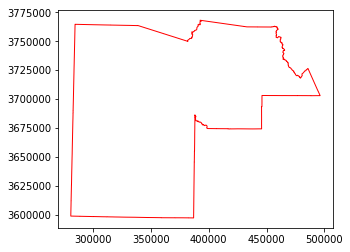

In [4]:
clipping_boundary.plot(edgecolor='red', facecolor='none')

## 2. Load GHSL bulit-up raster data and clip based on study region boundary
If the study region population raster files are seperated in different parts by GHS, we could read all the data file and merge into one raster mosaic. Referece post: [Creating a raster mosaic](https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html)

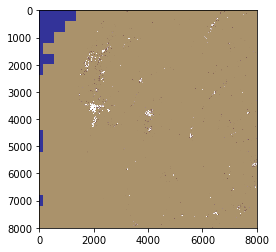

In [3]:
datasets = [urban_raster_file1, urban_raster_file2, urban_raster_file3, urban_raster_file4]
builtup_raster =  '../data/Population/{}_{}.tif'.format('builtup', placename)

save_studyregion_GHS_raster(datasets, builtup_raster)

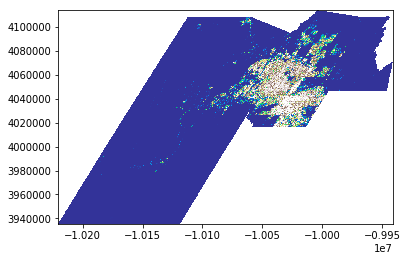

In [4]:
builtup_raster_clipped =  '../data/Population/{}_clipped_{}.tif'.format('builtup', placename)
raster_built = clip_studyregion_GHS_raster(clipping_boundary, builtup_raster, builtup_raster_clipped)

show(raster_built, cmap='terrain')

## 3. Define population projection based on studyregion file

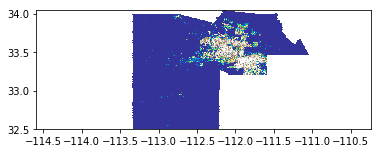

In [5]:
# reproject based on the original study region crs, and save the re-projected clipped raster
# need to discuss projection for study regions
builtup_raster_projected = '../data/Population/{}_clipped_{}.tif'.format('builtup_proj', placename)

raster_builtup_proj =  reproject_raster(inpath = builtup_raster_clipped, 
              outpath = builtup_raster_projected, 
              new_crs = to_crs) 

show(raster_builtup_proj, cmap='terrain')

## 4. Convert built-up raster to polygon features and geodataframe
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

In [6]:
polygonized_raster_gdf = raster_to_gdf(builtup_raster_projected, to_crs)
polygonized_raster_gdf.head()

,geometry,raster_val
1,"POLYGON ((-112.155423045832 34.04569640043506,...",0.5760
2,POLYGON ((-112.1519390666688 34.04569640043506...,8.1072
3,POLYGON ((-112.1519390666688 34.03524446294559...,1.6416
4,POLYGON ((-112.1484550875057 34.03524446294559...,1.3200
5,POLYGON ((-112.1484550875057 34.02827650461928...,5.9248


In [33]:
#save the population dataframe shapefile
ox.save_gdf_shapefile(polygonized_raster_gdf, filename='GHS_proj_2014builtup_250m_{}'.format(placename), folder=pop_folder)

## 5. Plot built-up raster based on study region boundary

In [4]:
# load study region boundary file and project to lat-long
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)

clipping_boundary = clipping_boundary.to_crs(to_crs)

In [35]:
def map_variable(df, df1, col):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme='quantiles', k=6, cmap='YlOrBr', figsize=(8,8))
    ax = df1.plot(ax=ax, facecolor="none", edgecolor='blue', linewidth=1)
    plt.show()

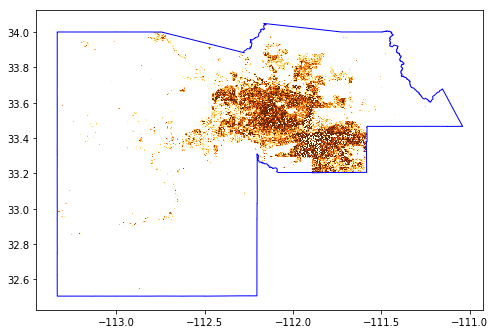

In [36]:
map_variable(polygonized_raster_gdf, clipping_boundary, 'raster_val')

- values reflect built-up area density

In [3]:
#load builtup area raster
builtup2014 = gpd.GeoDataFrame.from_file(GHS_builtup_filepath)

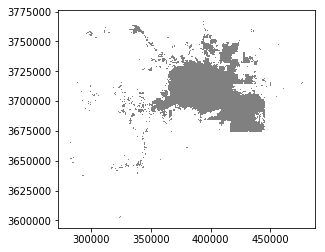

In [12]:
ax = builtup2014.envelope.plot(color='gray')
#ax = builtup2014.convex_hull.plot(ax=ax, color='b')